In [1]:
import pandas as pd
import scipy.stats as si
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### Load libraries ###

# interactive plotting
%matplotlib inline
%config InlineBackend.figure_format = 'png' # ‘png’, ‘retina’, ‘jpeg’, ‘svg’, ‘pdf’

# plotting libraries
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()


# Data management libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Machine learning libraries
import math
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.neural_network import  MLPClassifier, MLPRegressor

# XAI libraries
import dalex as dx
from lime.lime_tabular import LimeTabularExplainer 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Other libraries
# from utils import plotModelGridError, confusion_matrix
from neuralsens import partial_derivatives as ns
from sklearn import set_config
set_config(display='diagram')

### 1. Data load and split

In [2]:
def black_scholes_call_option(S, K, T, r, sigma):
    """
    Calculate the Black-Scholes price of a European call option.
    
    Parameters:
    S: Current stock price.
    K: Strike price of the option.
    T: Time to expiration in years.
    r: Risk-free interest rate (annualized).
    sigma: Volatility of the underlying stock (annualized).
    Returns:
        The Black-Scholes price of the call option.
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call_price = (S * si.norm.cdf(d1, 0.0, 1.0) - 
                  K * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0))
    
    return call_price


In [3]:
df = pd.read_csv('../data/processed/calls_2025_06_07.csv')
df = df.dropna()
df_final = df[['price', 'strike', 'T', 'impliedVolatility', 'midPrice','openInterest','volume', 'inTheMoney']].copy()

# Rename columns for clarity
df_final.rename(columns={
    'price': 'S',  # Current stock price
    'strike': 'K',  # Strike price
    'T': 'T',  # Time to expiration in years
    'impliedVolatility': 'sigma',  # Volatility of the underlying stock
    'midPrice': 'call_price'  # Black-Scholes price of the call option
}, inplace=True)

# Change inTheMoney to binary 
df_final['inTheMoney'] = df_final['inTheMoney'].astype(int)


In [4]:
df_final.columns.drop('call_price').tolist()

['S', 'K', 'T', 'sigma', 'openInterest', 'volume', 'inTheMoney']

In [5]:
INPUTS = df_final.columns.drop('call_price').tolist()
TARGET = 'call_price'

X = df_final[INPUTS]
y = df_final[TARGET]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
## Create dataset to store model predictions
dfTR_eval = X_train.copy()
dfTR_eval['midPrice'] = y_train
dfTS_eval = X_test.copy()
dfTS_eval['midPrice'] = y_test

In [7]:
dfTS_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25299 entries, 54071 to 118385
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   S             25299 non-null  float64
 1   K             25299 non-null  float64
 2   T             25299 non-null  float64
 3   sigma         25299 non-null  float64
 4   openInterest  25299 non-null  float64
 5   volume        25299 non-null  float64
 6   inTheMoney    25299 non-null  int64  
 7   midPrice      25299 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 1.7 MB


### 2. MLP

#### A. Train model

##### GRIDSEARCH

In [22]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create a preprocessor to perform the steps defined above
preprocessor = ColumnTransformer(transformers=[
        ('num', numeric_transformer, INPUTS)
        ])

param = {'MLP__alpha': [0.001], # Initial value of regularization
         'MLP__hidden_layer_sizes': [
                (80,),          # 1 capa con 50 neuronas
                (40, 40),      # 2 capas: 40 → 40
                (80, 40, 20),   # 3 capas: 80 → 40 → 20
        ],
         'MLP__learning_rate_init': [0.01, 0.001], # Initial learning rate
         'MLP__activation': ['tanh', 'relu'], # Activation function
}

pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('MLP', MLPRegressor(solver='adam', 
                max_iter=2000, # Maximum number of iterations
                tol=1e-4, # Tolerance for the optimization
                random_state=150,
                verbose = True))]) # For replication

# We use Grid Search Cross Validation to find the best parameter for the model in the grid defined 
nFolds = 10
MLP_fit = GridSearchCV(estimator=pipe, # Structure of the model to use
                       param_grid=param, # Defined grid to search in
                       n_jobs=-1, # Number of cores to use (parallelize)
                       scoring='neg_mean_squared_error', # RMSE https://scikit-learn.org/stable/modules/model_evaluation.html
                       cv=nFolds,
                       verbose=2) # Number of Folds 
MLP_fit.fit(X_train[INPUTS], y_train) # Search in grid


# Save the model
import joblib
joblib.dump(MLP_fit, '../models/MLP_dense_moreParams.pkl')

Iteration 1, loss = 8725.29552322
Iteration 1, loss = 8558.35451955
Iteration 1, loss = 8570.62264207
Iteration 1, loss = 8569.43930680
Iteration 1, loss = 8782.48056165
Iteration 1, loss = 8531.64659207
Iteration 1, loss = 8417.14361118
Iteration 1, loss = 8501.04430693
Iteration 2, loss = 5512.14410146
Iteration 2, loss = 5499.38709177
Iteration 2, loss = 5659.18201177
Iteration 2, loss = 5524.76517682
Iteration 2, loss = 5687.79389185
Iteration 2, loss = 5497.79733282
Iteration 2, loss = 5417.30604279
Iteration 2, loss = 5449.13190530
Iteration 3, loss = 4226.86618461
Iteration 3, loss = 4196.36882330
Iteration 3, loss = 4378.27210010
Iteration 3, loss = 4355.50568680
Iteration 3, loss = 4236.00348056
Iteration 3, loss = 4232.92087495
Iteration 3, loss = 4132.65080988
Iteration 3, loss = 4197.50657644
Iteration 4, loss = 3555.72032920
Iteration 4, loss = 3428.07644969
Iteration 4, loss = 3458.09529064
Iteration 4, loss = 3401.40675274
Iteration 4, loss = 3539.01980511
Iteration 4, l

['../models/MLP_dense_moreParams.pkl']

##### NoGRIDSEARCH

In [ ]:
numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])

# Create the preprocessor pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, INPUTS)
])

# Create the full pipeline with best hyperparameters
pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('MLP', MLPRegressor(
        hidden_layer_sizes=(80, 40, 20),
        activation='relu',
        alpha=0.001,
        learning_rate_init=0.01,
        solver='adam',
        max_iter=2000,
        tol=1e-4,
        random_state=150,
        verbose=True
    ))
])

# Fit the model
pipe.fit(X_train[INPUTS], y_train)

# Save the trained pipeline
joblib.dump(pipe, '../models/MLP_dense_BSParams.pkl')

['../models/MLP_dense_BSParams.pkl']

#### B. Load Model

In [8]:
import joblib

# Cargamos el modelo guardado
MLP_fit = joblib.load('../models/MLP_dense_moreParams.pkl')

### 3. MLP vs Black-Scholes

#### A. Graphic

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plotModelGridError(MLP_fit):
    results = MLP_fit.cv_results_
    mean_test_scores = results['mean_test_score']
    params = results['params']

    # Convertir a error (RMSE)
    errors = np.sqrt(-mean_test_scores)

    # Etiquetas incluyendo todos los hiperparámetros relevantes
    param_labels = [
        f"act: {p['MLP__activation']}, alpha: {p['MLP__alpha']}, size: {p['MLP__hidden_layer_sizes']}, lr: {p['MLP__learning_rate_init']}"
        for p in params
    ]

    # Obtener todos los learning rates únicos para codificarlos por color
    lrs = [p['MLP__learning_rate_init'] for p in params]
    unique_lrs = sorted(set(lrs))
    lr_color_map = {lr: cm.viridis(i / len(unique_lrs)) for i, lr in enumerate(unique_lrs)}
    bar_colors = [lr_color_map[lr] for lr in lrs]

    # Ordenar por error creciente
    sorted_indices = np.argsort(errors)
    errors_sorted = errors[sorted_indices]
    param_labels_sorted = [param_labels[i] for i in sorted_indices]
    bar_colors_sorted = [bar_colors[i] for i in sorted_indices]

    # Crear el gráfico
    plt.figure(figsize=(14, 8))
    bars = plt.barh(param_labels_sorted, errors_sorted, color=bar_colors_sorted)
    plt.xlabel("RMSE")
    plt.title("Model Grid Search Errors (RMSE), grouped by Learning Rate")
    plt.gca().invert_yaxis()
    plt.tight_layout()

    # Crear leyenda manual
    legend_handles = [
        plt.Rectangle((0, 0), 1, 1, color=lr_color_map[lr]) for lr in unique_lrs
    ]
    legend_labels = [f"lr: {lr}" for lr in unique_lrs]
    legend = plt.legend(legend_handles, legend_labels, title="Learning Rate", loc="upper right")

    # Quitar fondo de la leyenda
    legend.get_frame().set_facecolor('none')

    # Estética general
    ax = plt.gca()
    ax.set_facecolor('white')
    ax.grid(False)
    for spine in ax.spines.values():
        spine.set_edgecolor('black')
        spine.set_linewidth(0.5)
    
    plt.show()

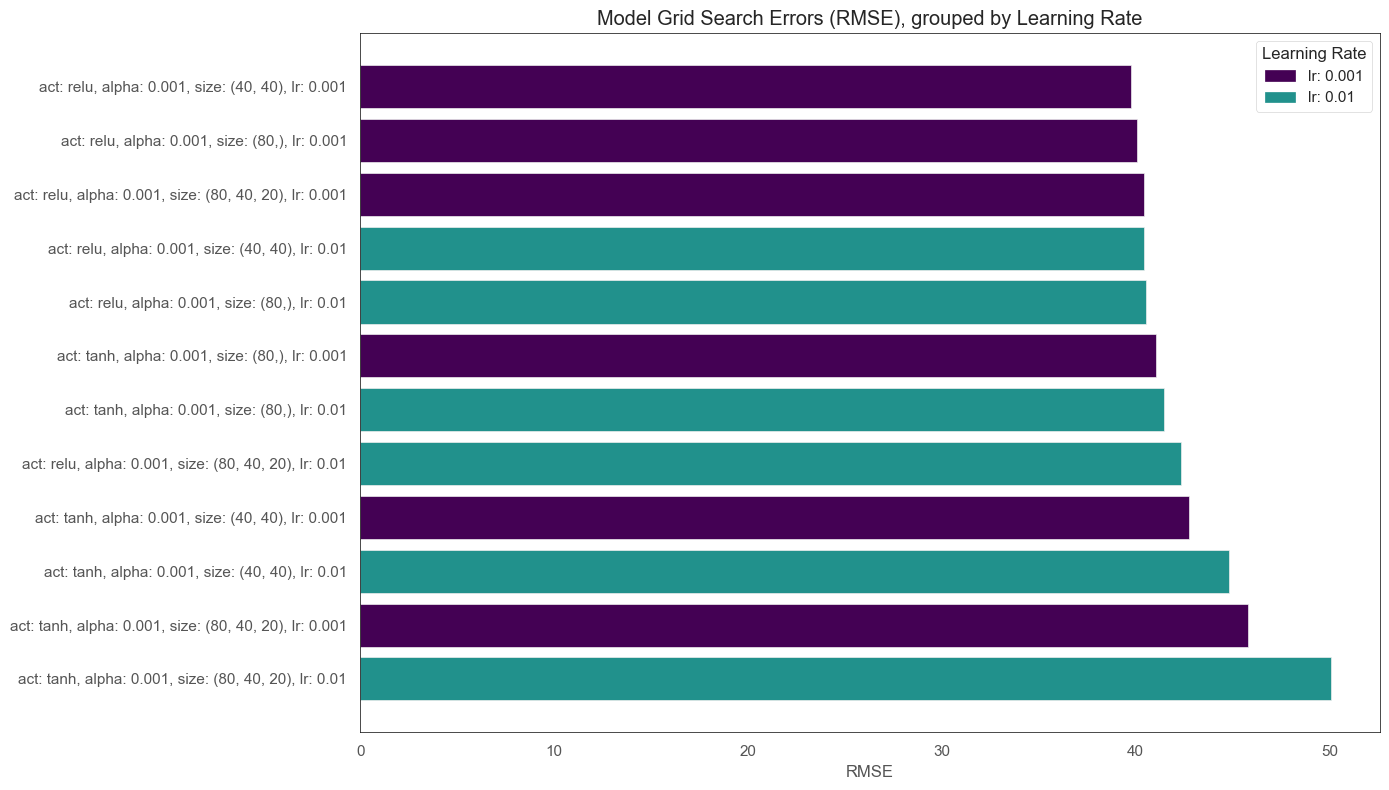

In [16]:
plotModelGridError(MLP_fit)
# La mejor combinación es ReLu, alpha=0.001, size=(80, 40, 20), lr=0.01

#### B. Comparison of metrics

In [103]:
# Calculate the predictions on the training set using Black-Scholes formula
dfTR_eval['BS_predict'] = black_scholes_call_option(
    dfTR_eval['S'],
    dfTR_eval['K'],
    dfTR_eval['T'],
    0.045,  # Assuming a risk-free interest rate of 5%
    dfTR_eval['sigma']
)

# Calculate the predictions on the test set using Black-Scholes formula
dfTS_eval['BS_predict'] = black_scholes_call_option(
    dfTS_eval['S'],
    dfTS_eval['K'],
    dfTS_eval['T'],
    0.045,  # Assuming a risk-free interest rate of 5%
    dfTS_eval['sigma']
)


In [104]:
dfTR_eval['MLP_pred'] = MLP_fit.predict(X_train[INPUTS])
dfTS_eval['MLP_pred'] = MLP_fit.predict(X_test[INPUTS])

In [105]:
#Training and test MAE - Mean Absolute error
print('MLP Predictions')
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['MLP_pred'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['MLP_pred'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['MLP_pred']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['MLP_pred']))

MLP Predictions
Training MAE: 7.223884845206329
Test MAE: 7.202581578422414
Training RMSE: 38.635822219795436
Test RMSE: 41.91976538075246
Training R2: 0.9322188515065822
Test R2: 0.920752400804147


In [106]:
print('Black-Scholes Predictions')
#Training and test MAE - Mean Absolute error
print('Training MAE:',mean_absolute_error(dfTR_eval['midPrice'], dfTR_eval['BS_predict']))
print('Test MAE:',mean_absolute_error(dfTS_eval['midPrice'], dfTS_eval['BS_predict']))
#Training and test RMSE - Root Mean Square Error
print('Training RMSE:',math.sqrt(mean_squared_error(dfTR_eval['midPrice'], dfTR_eval['BS_predict'])))
print('Test RMSE:',math.sqrt(mean_squared_error(dfTS_eval['midPrice'], dfTS_eval['BS_predict'])))
#Training and test r^2 
print('Training R2:',r2_score(dfTR_eval['midPrice'], dfTR_eval['BS_predict']))
print('Test R2:',r2_score(dfTS_eval['midPrice'], dfTS_eval['BS_predict']))

Black-Scholes Predictions
Training MAE: 8.873040536740485
Test MAE: 9.146334975830321
Training RMSE: 65.63617705197352
Test RMSE: 72.9164782442016
Training R2: 0.8043791413045844
Test R2: 0.7602272650786238


#### C. Case to case comparison

In [107]:
import numpy as np
dfTR_eval['MLP_diff'] = np.abs(dfTR_eval['midPrice'] - dfTR_eval['MLP_pred'])
dfTR_eval['BS_diff'] = np.abs(dfTR_eval['midPrice'] - dfTR_eval['BS_predict'])
dfTR_eval['MLP_better'] = dfTR_eval['MLP_diff'] < dfTR_eval['BS_diff']

# Casos en los que MLP es mejor
mlp_better_cases = dfTR_eval[dfTR_eval['MLP_better']]
bs_better_cases = dfTR_eval[~dfTR_eval['MLP_better']]

# Diferencias de error entre ambos modelos
mlp_margin = bs_better_cases['BS_diff'] - bs_better_cases['MLP_diff']
bs_margin = mlp_better_cases['MLP_diff'] - mlp_better_cases['BS_diff']

# Estadísticas descriptivas
print("Test set:")
print("BS ha aproximado mejor que MLP en", len(bs_better_cases), "casos.")
print("   Media de mejora:", mlp_margin.mean())
print("   Mediana de mejora:", mlp_margin.median())

print("MLP ha aproximado mejor que BS en", len(mlp_better_cases), "casos.")
print("   Media de mejora:", bs_margin.mean())
print("   Mediana de mejora:", bs_margin.median())

Test set:
BS ha aproximado mejor que MLP en 62903 casos.
   Media de mejora: -4.396186300237753
   Mediana de mejora: -1.6620642582273484
MLP ha aproximado mejor que BS en 38289 casos.
   Media de mejora: -11.58073257545456
   Mediana de mejora: -2.1654219113990187


In [108]:
dfTS_eval['MLP_diff'] = np.abs(dfTS_eval['midPrice'] - dfTS_eval['MLP_pred'])
dfTS_eval['BS_diff'] = np.abs(dfTS_eval['midPrice'] - dfTS_eval['BS_predict'])
dfTS_eval['MLP_better'] = dfTS_eval['MLP_diff'] < dfTS_eval['BS_diff']

# Casos en los que MLP es mejor
mlp_better_cases = dfTS_eval[dfTS_eval['MLP_better']]
bs_better_cases = dfTS_eval[~dfTS_eval['MLP_better']]

# Diferencias de error entre ambos modelos
mlp_margin = bs_better_cases['BS_diff'] - bs_better_cases['MLP_diff']
bs_margin = mlp_better_cases['MLP_diff'] - mlp_better_cases['BS_diff']

# Estadísticas descriptivas
print("Test set:")
print("BS ha aproximado mejor que MLP en", len(bs_better_cases), "casos.")
print("   Media de mejora:", mlp_margin.mean())
print("   Mediana de mejora:", mlp_margin.median())

print("MLP ha aproximado mejor que BS en", len(mlp_better_cases), "casos.")
print("   Media de mejora:", bs_margin.mean())
print("   Mediana de mejora:", bs_margin.median())

Test set:
BS ha aproximado mejor que MLP en 15742 casos.
   Media de mejora: -4.23924560171897
   Mediana de mejora: -1.6646841893345374
MLP ha aproximado mejor que BS en 9557 casos.
   Media de mejora: -12.128201471516446
   Mediana de mejora: -2.0965356890559974


### 4. Neuralsense

In [87]:
mlp = MLP_fit.best_estimator_['MLP']
wts = mlp.coefs_
bias = mlp.intercepts_
actfunc = ['identity',MLP_fit.best_estimator_['MLP'].get_params()['activation'],mlp.out_activation_]
X = MLP_fit.best_estimator_['preprocessor'].transform(X_train) # Preprocess the variables
coefnames = MLP_fit.best_estimator_['preprocessor'].get_feature_names_out(INPUTS)


In [67]:
actfunc = ['identity', 'relu', 'relu', 'identity']

In [68]:
X = pd.DataFrame(X, columns=coefnames)
y = pd.DataFrame(y_train, columns=[TARGET])
sens_end_layer = 'last'
sens_end_input = False
sens_origin_layer = 0
sens_origin_input = True

In [69]:
sensmlp = ns.jacobian_mlp(wts, bias, actfunc, X, y,)

In [70]:
sensmlp.summary()

Sensitivity analysis of [7, 40, 40, 1] MLP network.

Sensitivity measures of each output:

$call_price 

                         mean         std  mean_squared
num__S             277.466972  183.167666    332.473028
num__K            -225.306202  166.911063    280.396483
num__T              23.084730   42.281022     48.172498
num__sigma          41.869189   83.710556     93.597469
num__openInterest   -0.188977    0.914965      0.934276
num__volume          0.989610    2.512269      2.700153
num__inTheMoney     39.914061  102.665196    110.151145


In [71]:
sensmlp.info()

Sensitivity analysis of [7, 40, 40, 1] MLP network.

101192 samples

Sensitivities of each output (only 5 first samples):

$call_price 

       num__S      num__K     num__T  num__sigma  num__openInterest  \
0   72.685679  -52.180917  14.841730    3.551779           0.016046   
1  141.713604  -95.726598  18.286511   28.450128          -0.316081   
2  514.322638 -436.596055   0.582152   58.791729          -0.278513   
3   -2.069361   -3.154332   2.363303    1.521308           0.299499   
4   32.619028  -18.672995   0.322163   33.627357          -0.184647   

   num__volume  num__inTheMoney  
0    -0.049834         0.956260  
1    -0.565755       -27.217809  
2     1.948780       125.435071  
3     0.415613         0.177775  
4    -1.422913       -34.528073  


/Users/juan/anaconda3/envs/TFM/lib/python3.10/site-packages/neuralsens/partial_derivatives.py:1749: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  sns.barplot(


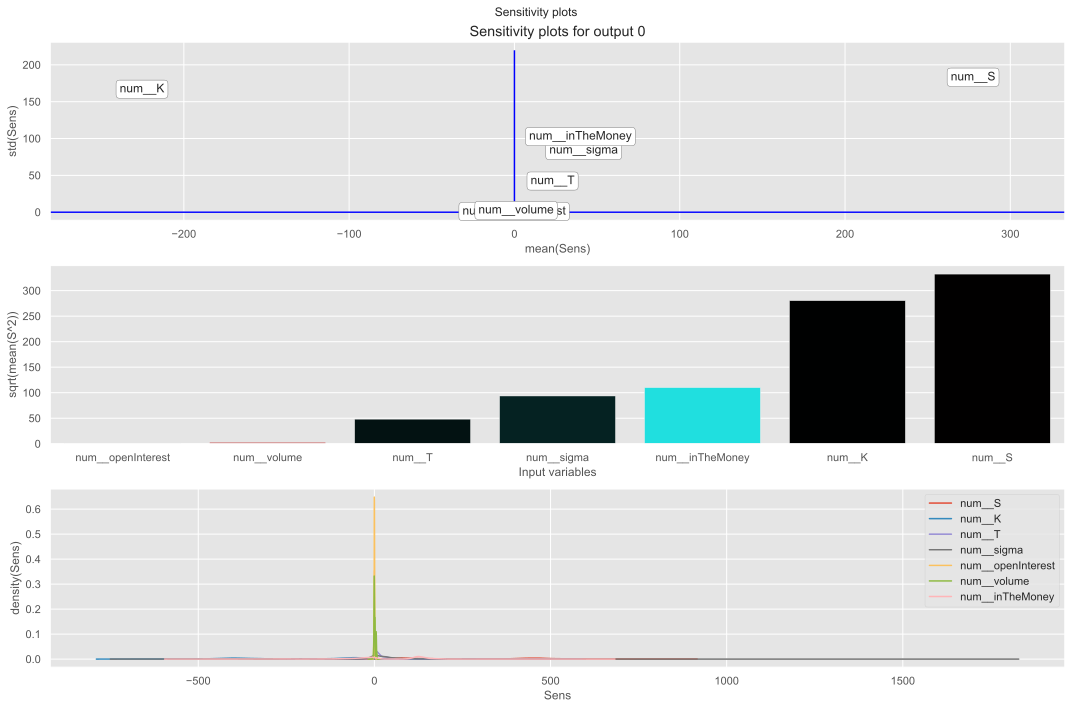

In [72]:
sensmlp.plot()

array([<Axes: xlabel='$\\alpha$', ylabel='$(ms_{X,j}^\\alpha(f))$'>,
       <Axes: >], dtype=object)

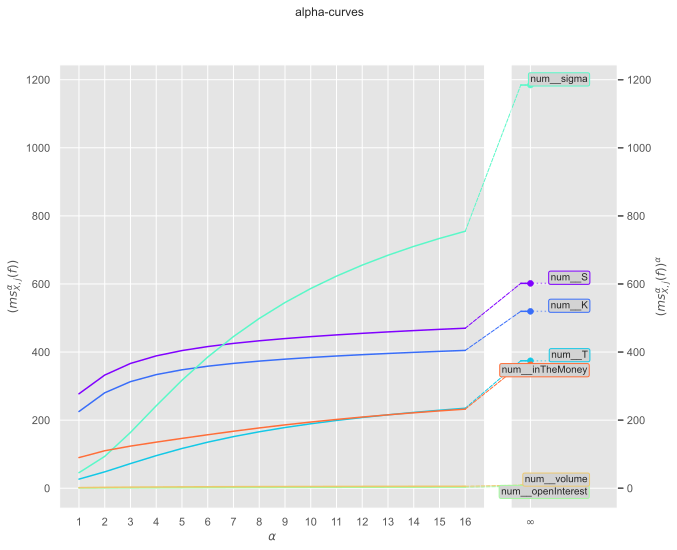

In [73]:
ns.alpha_sens_curves(sensmlp)

In [74]:
df_partDeriv = sensmlp.raw_sens[0]

In [75]:
df_partDeriv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101192 entries, 0 to 101191
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   num__S             101192 non-null  float64
 1   num__K             101192 non-null  float64
 2   num__T             101192 non-null  float64
 3   num__sigma         101192 non-null  float64
 4   num__openInterest  101192 non-null  float64
 5   num__volume        101192 non-null  float64
 6   num__inTheMoney    101192 non-null  float64
dtypes: float64(7)
memory usage: 5.4 MB


In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_partial_derivative_distributions(df):
    """
    Dibuja histogramas con líneas de media y mediana para cada derivada parcial,
    adaptándose dinámicamente al número de columnas del DataFrame.

    Args:
        df (pd.DataFrame): DataFrame con columnas como num__S, num__K, etc.
    """
    n = len(df.columns)
    cols = 2
    rows = int(np.ceil(n / cols))

    plt.figure(figsize=(cols * 7, rows * 4))
    for i, column in enumerate(df.columns, 1):
        plt.subplot(rows, cols, i)
        sns.histplot(df[column], kde=True, bins=100)
        plt.axvline(df[column].mean(), color='red', linestyle='--', label=f"Media: {df[column].mean():.2f}")
        plt.axvline(df[column].median(), color='green', linestyle=':', label=f"Mediana: {df[column].median():.2f}")
        plt.title(f"Distribución de ∂Precio/∂{column.split('__')[-1]}")
        plt.xlabel("Valor de la derivada parcial")
        plt.ylabel("Frecuencia")
        plt.legend()

    plt.tight_layout()
    plt.show()

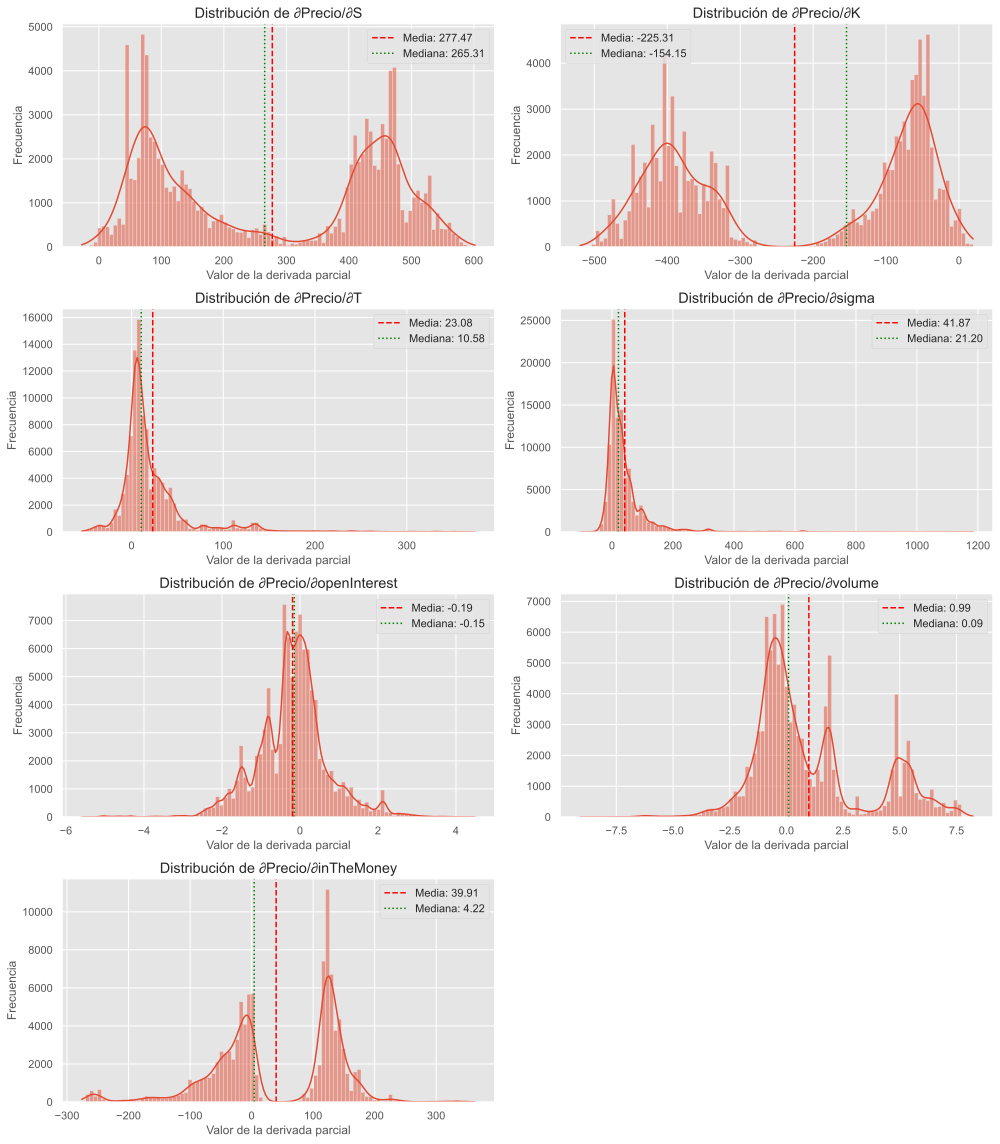

In [79]:
plot_partial_derivative_distributions(df_partDeriv)

In [80]:
def get_outliers_std(df, column, n_std=3):
    media = df[column].mean()
    std = df[column].std()
    return df[np.abs(df[column] - media) > n_std * std]

In [86]:
outliers_sigma = get_outliers_std(df_partDeriv, 'num__sigma', n_std=3)

## get a subdataframe with the outliers using the positional index in outlier_indices
outlier_rows = dfTR_eval.iloc[outliers_sigma.index]
# Display the outlier rows
outlier_rows.head(50)

# Mostrar los outliers en el conjunto de entrenamiento
print("Outliers in the training set:")
outlier_rows.head(50)

Outliers in the training set:


,S,K,T,sigma,openInterest,volume,inTheMoney,midPrice,BS_predict,MLP_pred,MLP_diff,BS_diff,MLP_better
90498,1241.47,540.0,0.780822,0.000010,6.0,2.0,1,677.650,720.114499,492.544849,185.105151,42.464499,False
20334,5614.61,5560.0,0.052055,0.252205,2.0,2.0,1,151.950,164.732394,134.852957,17.097043,12.782394,False
15828,791.85,460.0,0.780822,0.000010,1.0,1.0,1,150.600,347.732351,215.527472,64.927472,197.132351,True
21181,5614.61,5100.0,1.027397,0.380570,11.0,1.0,1,1086.000,1227.464357,1085.410978,0.589022,141.464357,True
18533,989.05,870.0,1.528767,0.282081,2.0,2.0,1,192.500,232.235651,196.699451,4.199451,39.735651,True
15134,3719.24,3110.0,0.032877,0.615574,6.0,1.0,1,611.850,622.315928,654.960232,43.110232,10.465928,False
90139,1241.47,90.0,0.531507,0.000010,1.0,1.0,1,603.000,1153.597064,835.851748,232.851748,550.597064,True
91017,1241.47,1240.0,1.605479,0.442165,57.0,1.0,1,271.825,310.352618,240.288549,31.536451,38.527618,True
51118,1775.10,1540.0,0.032877,0.543767,2.0,2.0,1,242.550,242.645857,263.348768,20.798768,0.095857,False
20361,5614.61,5610.0,0.068493,0.258304,3.0,3.0,1,143.500,162.285860,123.226817,20.273183,18.785860,False


In [36]:
outliers_T = get_outliers_std(df_partDeriv, 'num__T', n_std=3)
outlier_rows_T = dfTR_eval.iloc[outliers_T.index]
# Display the outlier rows for T
outlier_rows_T.head(10)

,S,K,T,sigma,midPrice,BS_predict,MLP_pred
1608,412.23,367.5,0.002740,1.290043,44.475,45.252410,63.274039
88692,57.46,27.0,0.002740,4.976566,30.800,30.468848,21.839552
79617,140.22,45.0,0.060274,2.735355,96.400,96.283884,94.561327
108521,23.18,18.0,0.002740,2.031255,5.325,5.188486,-2.397472
54413,1619.94,2900.0,0.136986,0.670902,2.000,1.839285,-8.789537
21908,5475.26,5050.0,0.309589,0.374503,671.050,725.274694,667.310561
22001,5475.26,4860.0,0.386301,0.393458,856.750,923.651096,862.809864
7112,173.38,110.0,0.002740,2.167973,63.475,63.393667,54.126889
88703,57.46,45.0,0.002740,1.792970,12.700,12.472399,11.564038
79905,469.98,522.5,0.002740,0.937989,2.150,0.134918,35.192955


In [37]:
outliers_K = get_outliers_std(df_partDeriv, 'num__K', n_std=3)
outlier_rows_K = dfTR_eval.iloc[outliers_K.index]
outlier_rows_K.head(10)

,S,K,T,sigma,midPrice,BS_predict,MLP_pred
95499,1208.550,220.0,0.558904,0.000010,463.775,994.014149,760.335055
22079,5475.260,3220.0,0.558904,0.583351,2354.650,2420.646073,2156.485336
95141,1208.550,720.0,0.213699,0.737033,497.875,503.648013,499.728534
95501,1208.550,240.0,0.558904,0.000010,703.275,974.510890,736.849971
38957,1013.140,580.0,0.213699,0.727054,438.625,443.465796,434.397539
126301,356.900,165.0,0.002740,2.843753,191.925,191.920342,190.086268
81209,315.745,125.0,0.213699,1.198734,192.975,193.938449,190.619642
95691,1208.550,270.0,0.635616,0.000010,348.000,946.163339,704.608266
87751,643.580,140.0,1.632877,0.568120,504.950,514.465031,528.665841
95683,1208.550,195.0,0.635616,0.000010,411.000,1019.048523,792.643399


In [30]:
outlier_rows[outlier_rows['sigma']== 0].head(50)

,S,K,T,sigma,midPrice,BS_predict,MLP_pred
